# CoSynthEx user manual

Below we present examples of how to use the main functions of the software.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import CoSynthEx as cse

## Specify file paths

In [2]:
input_path = '../input_data/'
output_path = '../output_data/'

## Load Real Data

For this example we will use expression and phenotypic data of rice (Oryza sativa). The RNA-seq data was accessed from the GEO database (accession number [GSE98455](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE98455)). It corresponds to $57\,845$ gene expression profiles of shoot tissues measured for control and salt conditions in $92$ accessions of the [Rice Diversity Panel 1](https://www.ars.usda.gov/southeast-area/stuttgart-ar/dale-bumpers-national-rice-research-center/docs/rice-diversity-panel-1-rdp1/), with $2$ biological replicates. The phenotypic data is a subset of the supplementary file 1 included in the work of [Campbell, M. T. (2017)](https://doi.org/10.1371/journal.pgen.1006823). A total of 3 phenotypic traits were used: shoot K content, and root and shoot biomass. These traits were measured for the same $92$ genotypes, under control and stress conditions.

### Raw count expression data

We will use only a random subset of genes to speed up the computation.

In [10]:
# Expression data
Expr_control = pd.read_csv(input_path + 'Exp_control_GSE98455.csv', index_col=0)
Expr_stress = pd.read_csv(input_path + 'Exp_stress_GSE98455.csv', index_col=0)
data_concat = pd.concat([Expr_control, Expr_stress], axis=1)

# random sample 5000 genes for proof of concept
data_concat = data_concat.sample(n=5000, axis=0) #,random_state=1)

count_data_real = data_concat.T #rows are samples, columns are genes

### Pre-processing

Gene expression data often follows a skewed or log-normal distribution, where most values are concentrated around a few low values with a long tail of high values. Applying a **log2 transformation** helps to make the data more symmetric and reduces the impact of extreme values. It can also make the data more amenable to linear modeling assumptions, which many machine learning algorithms, including neural networks, assume.

**Min-Max normalization** scales the data to a fixed range (typically between 0 and 1). This is often preferred when you want to preserve the relative differences in gene expression levels while ensuring that the data is within a consistent range. It helps neural networks converge more efficiently during training.

In [11]:
# log2 transformation
log_data_real = np.log2(count_data_real + 1)

# Min-max normalization
# minmax_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
# scaled_data_real = minmax_scaler.fit_transform(log_data_real.values)

# manual Min-max normalization
eps=1e-8
log_min = log_data_real.values.min()
log_max = log_data_real.values.max()
scaled_data_real = log_data_real.apply(lambda x: (x-log_min+eps)/(log_max-log_min+eps))

# scaled_data_real as dataframe
scaled_data_real = pd.DataFrame(scaled_data_real, index=log_data_real.index, columns=log_data_real.columns)

# dimensions of expression data
sample_length = len(log_data_real.columns)
num_samples = len(log_data_real.index)

### Covariates data 
(sample condition and phenotype values)

In [12]:
sample_info_real = pd.read_csv(input_path + 'sample_info_GSE98455.csv', index_col=0)
sample_info_real['name'] = sample_info_real.index
sample_info_real['genotype'] = sample_info_real['genotype'].astype(str)
sample_info_real['genotype_name'] = sample_info_real[['genotype', 'name']].apply(lambda x: '_'.join(x), axis=1)

control_samples = sample_info_real[sample_info_real.condition == 'control'].index
stress_samples = sample_info_real[sample_info_real.condition == 'stress'].index

# categorical variable (control or stress)
conditions = ['control','stress']
condition_data = pd.Series(pd.factorize(sample_info_real['condition'])[0])

# numerical variables (phenotype: K_shoot, BM_root, BM_shoot)
traits = ['K_shoot', 'BM_root', 'BM_shoot']
phenotype_data_real_df = sample_info_real[['condition'] + traits]
phenotype_data_real = sample_info_real[traits].values

## Define parameters

In [6]:
# parameters for cGAN
input_size = sample_length
hidden_size = 80
output_size = sample_length
n_covariates = 4 # condition (control/stress) + 3 phenotypic traits
num_epochs = 200
batch_size = 46
learning_rate = 0.0001

## Train cGAN

In [13]:
# create model
G = cse.Generator(input_size, n_covariates, hidden_size, output_size)
D = cse.Discriminator(input_size, n_covariates, hidden_size)

# loss function
criterion = nn.BCELoss()

# optimizer
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

# train model
D_losses, G_losses, G, D = cse.train_model(G, D, criterion, G_optimizer, D_optimizer,
                                       num_epochs, batch_size, input_size,
                                       scaled_data_real, condition_data, phenotype_data_real_df[traits])

# save trained model
torch.save(G.state_dict(), output_path + 'G.pth')
torch.save(D.state_dict(), output_path + 'D.pth')

100%|███████████████████████████████████████████████████| 200/200 [00:29<00:00,  6.76it/s]


## Plot loss curves

The generator's loss should initially be high and then decrease over time. It should ideally converge to a low value. This indicates that the generator is learning to generate data that is increasingly more similar to the real data distribution.

The discriminator's loss should start relatively high and gradually decrease. It should ultimately plateau or oscillate around a low value. This indicates that the discriminator is having a harder time distinguishing between real and generated data, which is a sign of successful training. 

Ideally, the generator and discriminator should be in a state of competition and adaptation throughout training. The generator aims to produce data that is increasingly convincing to the discriminator, while the discriminator tries to become better at distinguishing real from fake data.

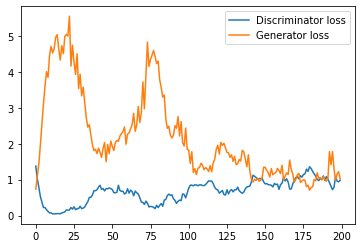

In [8]:
cse.plot_loss(D_losses, G_losses, output_path_figures = output_path)

## Load pre-trained cGAN

If you have already trained the cGAN and saved the discriminator and generator, you can load them without needing to retrain the model.

In [9]:
# load trained model
# G = cse.Generator(input_size, n_covariates, hidden_size, output_size)
# D = cse.Discriminator(input_size, n_covariates, hidden_size)
# G.load_state_dict(torch.load(output_path + 'G.pth'))
# D.load_state_dict(torch.load(output_path + 'D.pth'))

## Use trained cGAN to generate synthetic data

With the trained caGAN you can generate synthetic expression data using the actual phenotypic data for the corresponding control and stress samples. You can also reverse the initial transformations of the data to obtain the raw counts.

In [10]:
 # generate fake expression data
noise = torch.randn(num_samples, input_size)
condition = torch.tensor(condition_data, dtype=torch.float32).view(-1, 1)
phenotype = torch.tensor(phenotype_data_real, dtype=torch.float32)
scaled_data_fake = G(noise, condition, phenotype)
scaled_data_fake = scaled_data_fake.detach().numpy()
scaled_data_fake = pd.DataFrame(scaled_data_fake, index=sample_info_real.index, columns=count_data_real.columns)

# reverse minmax scaler into a dataframe
# log_data_fake = minmax_scaler.inverse_transform(scaled_data_fake)
log_data_fake = scaled_data_fake.apply(lambda x: x*(log_max-log_min) + log_min)
log_data_fake = pd.DataFrame(log_data_fake, index=scaled_data_fake.index, columns=scaled_data_fake.columns)
# reverse log2 transformation into a dataframe
count_data_fake = np.power(2, log_data_fake) - 1

## Plot results

We can plot a compendium of all the expression data generated. It can be seen how the synthetic data are quite close to the distribution of the real data. However, at this scale it is not possible to appreciate the difference between the control and stress data.

<Figure size 432x288 with 0 Axes>

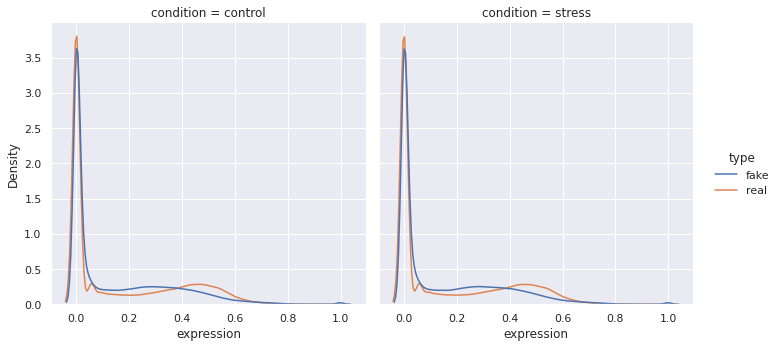

In [11]:
cse.plot_all_expression_fake_vs_real(scaled_data_real, scaled_data_fake, output_path)

To better appreciate the difference between the control and stress data, you have to focus on one gene. As shown below, it is possible to graph the real and synthetic expression of a random gene, where the difference between the control and stress data can be seen.

<Figure size 432x288 with 0 Axes>

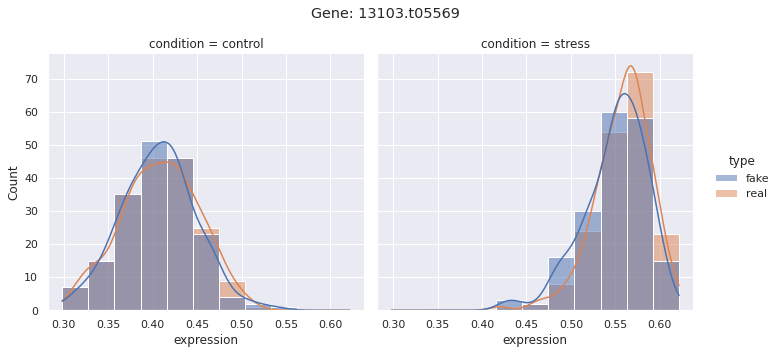

In [12]:
gene = cse.plot_gene_expression_fake_vs_real(control_samples, stress_samples,
                                             scaled_data_real, scaled_data_fake,
                                            output_path_figures=output_path)